# Boosting

In [1]:
# !conda install -c anaconda py-xgboost

In [2]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor,\
GradientBoostingClassifier
import xgboost  # You may need to install this!
import pandas as pd
import matplotlib as mpl
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix
%matplotlib inline

## Agenda

SWBAT:

- describe boosting algorithms;
- implement boosting models with `sklearn` and with `XGBoost`.

## Intro

One of the problems with using single decision trees and random forests is that, once I make a split, I can't go back and consider how another feature varies across the whole dataset. But suppose I were to consider **my tree's errors**. The fundamental idea of ***boosting*** is to start with a weak learner and then to use information about its errors to build a new model that can supplement the original model.

## Two Types

The two main types of boosting available in Scikit-Learn are adaptive boosting (AdaBoostClassifier, AdaBoostRegressor) and gradient boosting (GradientBoostingClassifier, GradientBoostingRegressor).

Again, the fundamental idea of boosting is to use a sequence of **weak** learners to build a model. Though the individual learners are weak, the idea is to train iteratively in order to produce a better predictor. More specifically, the first learner will be trained on the data as it stands, but future learners will be trained on modified versions of the data. The point of the modifications is to highlight the "hard-to-predict-accurately" portions of the data.

- **AdaBoost** works by iteratively adapting two related series of weights, one attached to the datapoints and the other attached to the learners themselves. Datapoints that are incorrectly classified receive greater weights for the next learner in the sequence. That way, future learners will be more likely to focus on those datapoints. At the end of the sequence, the learners that make better predictions, especially on the datapoints that are more resistant to correct classification, receive more weight in the final "vote" that determines the ensemble's prediction. <br/> Suppose we have a binary classification problem and we represent the two classes with 1 and -1. (This is standard for describing the algorithm of AdaBoost.) <br/>
Then, in a nutshell: <br/>
    1. Train a weak learner. <br/>
    2. Calculate its error $\epsilon$. <br/>
    3. Use that error as a weight on the classifier: $\theta = \frac{1}{2}ln\left(\frac{1-\epsilon}{\epsilon}\right)$. <br/>
    Note that $\theta$ CAN be negative. This represents a classifier whose accuracy is _worse_ than chance. <br/>
    4. Use _that_ to adjust the data points' weights: $w_{n+1} = w_n\left(\frac{e^{\pm\theta}}{scaler}\right)$. Use $+\theta$ for incorrect predictions, $-\theta$ for correct predictions. <br/>  $\rightarrow$ For more detail on AdaBoost, see [here](https://towardsdatascience.com/boosting-algorithm-adaboost-b6737a9ee60c).

- **Gradient Boosting** works instead by training each new learner on the residuals of the model built with the learners that have so far been constructed. That is, Model $n+1$ (with $n+1$ learners) will focus on the predictions of Model $n$ (with only $n$ learners) that were **most off the mark**. As the training process repeats, the learners learn and the residuals get smaller. I would get a sequence going: <br/> Model 0 is very simple. Perhaps it merely predicts the mean: <br/>
$\hat{y}_0 = \bar{y}$; <br/>
Model 1's predictions would then be the sum of (i) Model 0's predictions and (ii) the predictions of the model fitted to Model 0's residuals: <br/> $\hat{y}_1 = \hat{y}_0 + \hat{(y - \hat{y})}_{err0}$; <br/>
Now iterate: Model 2's predictions will be the sum of (i) Model 0's predictions, (ii) the predictions of the model fitted to Model 0's residuals, and (iii) the predictions of the model fitted to Model 1's residuals: <br/> $\hat{y}_2 = \hat{y}_0 + \hat{(y - \hat{y})}_{err0} + \hat{(y - \hat{y})}_{err1}$<br/>
Etc.
<br/>

$\rightarrow$ How does gradient boosting work for a classification problem? How do we even make sense of the notion of a gradient in that context? The short answer is that we appeal to the probabilities associated with the predictions for the various classes. See more on this topic [here](https://sefiks.com/2018/10/29/a-step-by-step-gradient-boosting-example-for-classification/). <br/> $\rightarrow$ Why is this called "_gradient_ boosting"? The short answer is that fitting a learner to a model's residuals comes to the same thing as fitting it to the derivative of that model's loss function. See more on this topic [here](https://www.ritchievink.com/blog/2018/11/19/algorithm-breakdown-why-do-we-call-it-gradient-boosting/).

Let's illustrate gradient boosting now!

## AdaBoost in Scikit-Learn

In [3]:
galaxies = pd.read_csv('COMBO17.csv')
galaxies.head()

,Nr,Rmag,e.Rmag,ApDRmag,mumax,Mcz,e.Mcz,MCzml,chi2red,UjMAG,...,UFS,e.UFS,BFS,e.BFS,VFD,e.VFD,RFS,e.RFS,IFD,e.IFD
0,6,24.995,0.097,0.935,24.214,0.832,0.036,1.400,0.64,-17.67,...,0.01870,0.00239,0.01630,0.00129,0.017300,0.00141,0.01650,0.000434,0.02470,0.00483
1,9,25.013,0.181,-0.135,25.303,0.927,0.122,0.864,0.41,-18.28,...,0.00706,0.00238,0.00420,0.00115,0.003930,0.00182,0.00723,0.000500,0.00973,0.00460
2,16,24.246,0.054,0.821,23.511,1.202,0.037,1.217,0.92,-19.75,...,0.01260,0.00184,0.01830,0.00115,0.018800,0.00167,0.02880,0.000655,0.05700,0.00465
3,21,25.203,0.128,0.639,24.948,0.912,0.177,0.776,0.39,-17.83,...,0.01410,0.00186,0.01180,0.00110,0.009670,0.00204,0.01050,0.000416,0.01340,0.00330
4,26,25.504,0.112,-1.588,24.934,0.848,0.067,1.330,1.45,-17.69,...,0.00514,0.00170,0.00102,0.00127,0.000039,0.00160,0.00139,0.000499,0.00590,0.00444


This is a dataset about galaxies. The Mcz and MCzml columns are measures of redshift, which is our target. Mcz is usually understood to be a better measure, so that will be our target column. Many of the other columns have to do with various measures of galaxies' magnitudes. For more on the dataset, see [here](https://astrostatistics.psu.edu/datasets/COMBO17.html).

In [4]:
galaxies.columns

Index(['Nr', 'Rmag', 'e.Rmag', 'ApDRmag', 'mumax', 'Mcz', 'e.Mcz', 'MCzml',
       'chi2red', 'UjMAG', 'e.UjMAG', 'BjMAG', 'e.BjMAG', 'VjMAG', 'e.VjMAG',
       'usMAG', 'e.usMAG', 'gsMAG', 'e.gsMAG', 'rsMAG', 'e.rsMAG', 'UbMAG',
       'e.UbMAG', 'BbMAG', 'e.BbMAG', 'VnMAG', 'e.VbMAG', 'S280MAG',
       'e.S280MA', 'W420FE', 'e.W420FE', 'W462FE', 'e.W462FE', 'W485FD',
       'e.W485FD', 'W518FE', 'e.W518FE', 'W571FS', 'e.W571FS', 'W604FE',
       'e.W604FE', 'W646FD', 'e.W646FD', 'W696FE', 'e.W696FE', 'W753FE',
       'e.W753FE', 'W815FS', 'e.W815FS', 'W856FD', 'e.W856FD', 'W914FD',
       'e.W914FD', 'W914FE', 'e.W914FE', 'UFS', 'e.UFS', 'BFS', 'e.BFS', 'VFD',
       'e.VFD', 'RFS', 'e.RFS', 'IFD', 'e.IFD'],
      dtype='object')

In [5]:
galaxies.isnull().sum().sum()

50

In [6]:
galaxies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3462 entries, 0 to 3461
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Nr        3462 non-null   int64  
 1   Rmag      3462 non-null   float64
 2   e.Rmag    3462 non-null   float64
 3   ApDRmag   3462 non-null   float64
 4   mumax     3462 non-null   float64
 5   Mcz       3462 non-null   float64
 6   e.Mcz     3462 non-null   float64
 7   MCzml     3462 non-null   float64
 8   chi2red   3462 non-null   float64
 9   UjMAG     3462 non-null   float64
 10  e.UjMAG   3462 non-null   float64
 11  BjMAG     3462 non-null   float64
 12  e.BjMAG   3462 non-null   float64
 13  VjMAG     3462 non-null   float64
 14  e.VjMAG   3462 non-null   float64
 15  usMAG     3462 non-null   float64
 16  e.usMAG   3462 non-null   float64
 17  gsMAG     3462 non-null   float64
 18  e.gsMAG   3462 non-null   float64
 19  rsMAG     3462 non-null   float64
 20  e.rsMAG   3462 non-null   floa

In [7]:
galaxies = galaxies.dropna()

Let's collect together the columns that have high correlation with Mcz, our target:

In [8]:
preds = []
for ind in galaxies.corr()['Mcz'].index:
    if abs(galaxies.corr()['Mcz'][ind]) > 0.5:
        preds.append(ind)

In [9]:
galaxies[preds].corr()

,Mcz,e.Mcz,MCzml,UjMAG,BjMAG,VjMAG,usMAG,gsMAG,rsMAG,UbMAG,BbMAG,VnMAG,S280MAG
Mcz,1.000000,0.613071,0.872016,-0.699550,-0.628226,-0.641983,-0.698304,-0.652170,-0.631398,-0.699731,-0.659506,-0.641870,-0.700453
e.Mcz,0.613071,1.000000,0.590179,-0.170296,-0.122309,-0.122616,-0.168326,-0.126491,-0.114022,-0.170208,-0.130680,-0.122546,-0.169344
MCzml,0.872016,0.590179,1.000000,-0.565663,-0.520006,-0.532880,-0.563591,-0.536750,-0.525495,-0.565406,-0.544325,-0.532837,-0.562474
UjMAG,-0.699550,-0.170296,-0.565663,1.000000,0.933252,0.961088,0.999865,0.970124,0.954853,0.999986,0.975476,0.960981,0.963415
BjMAG,-0.628226,-0.122309,-0.520006,0.933252,1.000000,0.950728,0.932328,0.954006,0.947597,0.932831,0.957836,0.950694,0.885382
VjMAG,-0.641983,-0.122616,-0.532880,0.961088,0.950728,1.000000,0.959432,0.997956,0.999324,0.960265,0.992178,0.999997,0.894171
usMAG,-0.698304,-0.168326,-0.563591,0.999865,0.932328,0.959432,1.000000,0.968971,0.953027,0.999903,0.974515,0.959320,0.964972
gsMAG,-0.652170,-0.126491,-0.536750,0.970124,0.954006,0.997956,0.968971,1.000000,0.995436,0.969562,0.995887,0.997923,0.914118
rsMAG,-0.631398,-0.114022,-0.525495,0.954853,0.947597,0.999324,0.953027,0.995436,1.000000,0.953909,0.988695,0.999341,0.882782
UbMAG,-0.699731,-0.170208,-0.565406,0.999986,0.932831,0.960265,0.999903,0.969562,0.953909,1.000000,0.975035,0.960155,0.964189


These various magnitude columns all have high correlations **with one another**! Let's try a simple model with just the S280MAG column, since it has the highest correlation with Mcz.

In [10]:
x = galaxies['S280MAG']
y = galaxies['Mcz']

Since we only have one predictor, we can visualize the correlation with the target! We can also reshape it for modeling purposes!

In [11]:
x_rev = x.values.reshape(-1, 1)

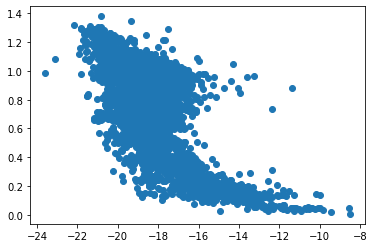

In [12]:
mpl.pyplot.scatter(x_rev, y);

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_rev, y, random_state=42)

In [14]:
abr = AdaBoostRegressor(random_state=42)

abr.fit(x_train, y_train)

AdaBoostRegressor(random_state=42)

In [15]:
cross_val_score(abr, x_train, y_train, cv=5)

array([0.48891095, 0.42071752, 0.53158551, 0.51183824, 0.44177733])

## Hyperparameter Tuning

Let's see if we can do better by trying different hyperparameter values:

In [16]:
gs = GridSearchCV(estimator=abr,
                 param_grid={
                     'n_estimators': [25, 50, 100],
                     'loss': ['linear', 'square']
                 }, cv=5)

In [17]:
gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42),
             param_grid={'loss': ['linear', 'square'],
                         'n_estimators': [25, 50, 100]})

In [18]:
gs.best_params_

{'loss': 'linear', 'n_estimators': 25}

## XGBoost

In [19]:
grad_boost = xgboost.XGBRegressor(random_state=42, objective='reg:squarederror')

grad_boost.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
cross_val_score(grad_boost, x_train, y_train, cv=5)

array([0.43487026, 0.39709885, 0.46508887, 0.47632543, 0.40770303])

## Regression or Classification?

What does my target look like?

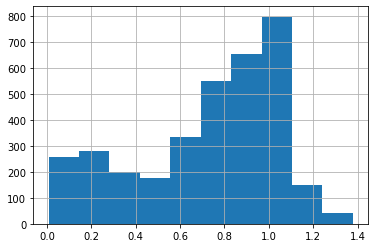

In [21]:
galaxies['Mcz'].hist();

There seems to be a bit of a bimodal shape here. We might therefore try predicting whether the redshift factor is likely to be greater or less than 0.5:

In [22]:
galaxies['bool'] = galaxies['Mcz'] > 0.5

In [23]:
galaxies.tail()

,Nr,Rmag,e.Rmag,ApDRmag,mumax,Mcz,e.Mcz,MCzml,chi2red,UjMAG,...,e.UFS,BFS,e.BFS,VFD,e.VFD,RFS,e.RFS,IFD,e.IFD,bool
3457,9990,24.962,0.186,-0.113,25.189,0.960,0.190,0.951,0.89,-18.21,...,0.00170,0.00361,0.001150,0.00489,0.00147,0.00625,0.000413,0.00987,0.00323,True
3458,9992,21.918,0.017,-0.562,23.063,0.770,0.031,0.766,0.90,-20.47,...,0.00218,0.04500,0.001310,0.05130,0.00173,0.07210,0.000542,0.10200,0.00477,True
3459,9995,23.701,0.051,-0.437,24.053,0.775,0.121,1.330,0.60,-18.76,...,0.00223,0.01850,0.001090,0.01450,0.00182,0.01580,0.000468,0.01860,0.00484,True
3460,9996,23.473,0.098,-1.114,25.075,0.926,0.087,0.870,1.01,-19.67,...,0.00225,0.00809,0.001190,0.01140,0.00166,0.01070,0.000454,0.01930,0.00390,True
3461,9997,25.621,0.298,-0.224,25.488,0.968,0.139,0.957,1.13,-17.70,...,0.00165,0.00315,0.000949,0.00247,0.00131,0.00317,0.000426,0.00746,0.00415,True


In [24]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_rev, galaxies['bool'])

### AdaBoost

In [25]:
abc = AdaBoostClassifier(random_state=42)

abc.fit(x_train2, y_train2)

AdaBoostClassifier(random_state=42)

In [26]:
abc.score(x_test2, y_test2)

0.8790697674418605

In [27]:
precision_score(y_test2, abc.predict(x_test2))

0.8986784140969163

In [28]:
recall_score(y_test2, abc.predict(x_test2))

0.9459041731066461

### GradientBoosting

In [29]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(x_train2, y_train2)

GradientBoostingClassifier(random_state=42)

In [30]:
gbc.score(x_test2, y_test2)

0.8790697674418605

In [31]:
precision_score(y_test2, gbc.predict(x_test2))

0.8940493468795355

In [32]:
recall_score(y_test2, gbc.predict(x_test2))

0.9520865533230294

In [33]:
confusion_matrix(y_test2, gbc.predict(x_test2))

array([[140,  73],
       [ 31, 616]])

### XGBoost

In [34]:
grad_boost_class = xgboost.XGBClassifier(random_state=42, objective='binary:logistic')

grad_boost_class.fit(x_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
grad_boost_class.score(x_test2, y_test2)

0.877906976744186